In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

# Setup the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: mps


/Users/yangshijie/miniconda3/envs/yolo_lcm/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## 1. Load Models


In [6]:
# Load YOLO and LCM
yolo_path = "yolov8n-seg.pt"
ctrl_net_path = "models/control_v11p_sd15_canny"
lcm_path = "models/LCM_Dreamshaper_v7"

yolo = YOLO(yolo_path).to(device)
ctrl_net = ControlNetModel.from_pretrained(ctrl_net_path, use_safetensors=True)
pipe = StableDiffusionControlNetPipeline.from_pretrained(lcm_path, controlnet=ctrl_net, safety_checker=None).to(device)
pipe.enable_attention_slicing()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


## 2. Load Images


In [16]:
size_yolo = 640
size_lcm = 512

# Load the video
cap = cv2.VideoCapture("video/passenger.mp4")

# Get the resolution of the video
cap_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
cap_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Compute the center crop start and end points
cap_size = min(cap_width, cap_height)
cap_crop_x, cap_crop_y = (cap_width - cap_size) // 2, (cap_height - cap_size) // 2

# Load the background image
img_back = cv2.imread("image/Tiantan_Beijing.png")

# Crop the background image to a square
img_back_width, img_back_height = img_back.shape[:2]
img_back_size = min(img_back_width, img_back_height)
img_back_crop_x, img_back_crop_y = (img_back_width - img_back_size) // 2, (img_back_height - img_back_size) // 2
img_back = img_back[img_back_crop_y:img_back_crop_y + img_back_size, img_back_crop_x:img_back_crop_x + img_back_size]

# Resize the background image to the LCM size
img_back = cv2.resize(img_back, (size_lcm, size_lcm))

## 3. Create a prompt to inpaint the image with and pass it to the pipeline with the base and mask images



0: 640x640 26 persons, 1 backpack, 1222.2ms
Speed: 370.9ms preprocess, 1222.2ms inference, 28.3ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 0/4 [00:00<?, ?it/s]

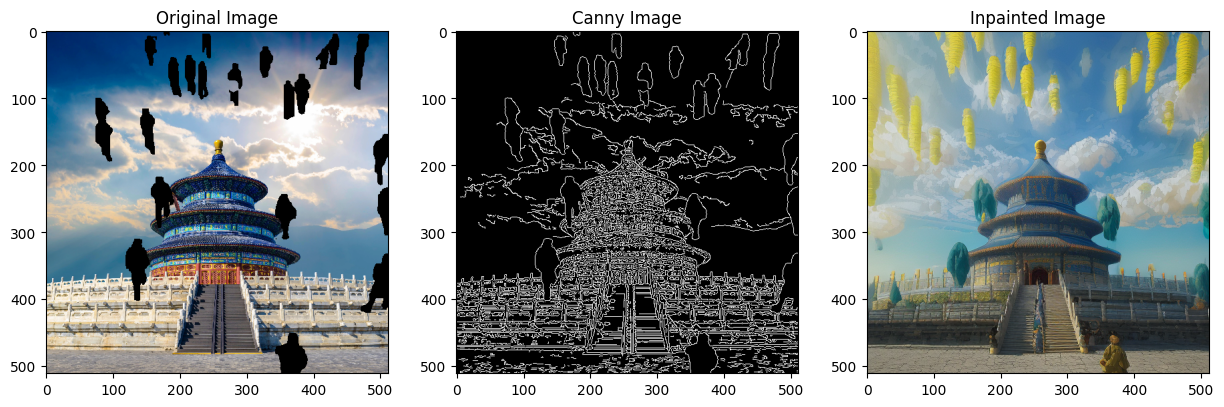

In [17]:
prompt = "The majestic Tiantan (Temple of Heaven) under the clear midday sky, with its ornate blue and gold rooftops glistening in the sunlight, surrounded by vibrant greenery and visitors exploring the historic site. serene, vibrant, cultural, 8k."
negative_prompt = "bad anatomy, deformed, ugly, disfigured, low quality, bad quality, sketches"
num_inference_steps = 4
guidance_scale = 4.0
controlnet_conditioning_scale = 1.2

# Read the frame
ret, frame = cap.read()

# Crop the frame to a square
frame = frame[cap_crop_y:cap_crop_y + cap_size, cap_crop_x:cap_crop_x + cap_size]

# Resize the frame for YOLO
frame = cv2.resize(frame, (size_yolo, size_yolo))

# Perform YOLO segmentation
result = yolo(frame)[0]

# Filter the person class
masks = result.masks.data
boxes = result.boxes.data
labels = boxes[:, 5].int()
person_masks = masks[labels == 0]

# Create a person mask
person_masks = person_masks.unsqueeze(1)
person_masks = torch.nn.functional.interpolate(person_masks, (size_lcm, size_lcm), mode="nearest")
person_mask = torch.sum(person_masks, dim=0).squeeze(0)

# %%
# LCM diffusion

# Mask the background image
img_comp = torch.from_numpy(img_back).to(device)
img_comp[person_mask > 0] = 0

# Canny edge detection
img_canny = cv2.Canny(img_comp.cpu().numpy(), 100, 200)
img_canny = np.stack([img_canny] * 3, axis=-1)
img_canny = Image.fromarray(img_canny)

# Generate final image with LCM
image = pipe(
    prompt                        = prompt,
    negative_prompt               = negative_prompt,
    image                         = img_canny,
    width                         = size_lcm,
    height                        = size_lcm,
    num_inference_steps           = num_inference_steps,
    guidance_scale                = guidance_scale,
    controlnet_conditioning_scale = controlnet_conditioning_scale,
    generator                     = torch.Generator("mps").manual_seed(19),
    guess_mode                    = True,
    output_type                   = "np",
).images[0]

# cv2.imshow("Person Extraction", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(img_comp.cpu().numpy(), cv2.COLOR_RGB2BGR))
ax[0].set_title("Original Image")
ax[1].imshow(img_canny)
ax[1].set_title("Canny Image")
ax[2].imshow(image)
ax[2].set_title("Inpainted Image")
plt.show()

In [12]:
# Convert the image and save it
image = (image * 255).astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite("image/Tian_inpainting.png", image)

True